# Quora Qustion Pair Problem

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score
import os
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer, wordnet
from nltk.corpus import stopwords
import bs4
from bs4 import BeautifulSoup
import distance

## Basic EDA

In [2]:
#Importing the dataset.

data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
#Basic EDA - checking the no of columns
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [5]:
#checking the shape of the data
data.shape 

(404290, 6)

In [6]:
#checking the data types of the data
data.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [7]:
#checking the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
#checking the null values in my data or not
data.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [9]:
data.describe(include = 'all')

,id,qid1,qid2,question1,question2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404289,404288,404290.000000
unique,NaN,NaN,NaN,290456,299174,NaN
top,NaN,NaN,NaN,How do I improve my English speaking?,How can you look at someone's private Instagra...,NaN
freq,NaN,NaN,NaN,50,120,NaN
mean,202144.500000,217243.942418,220955.655337,NaN,NaN,0.369198
std,116708.614502,157751.700002,159903.182629,NaN,NaN,0.482588
min,0.000000,1.000000,2.000000,NaN,NaN,0.000000
25%,101072.250000,74437.500000,74727.000000,NaN,NaN,0.000000
50%,202144.500000,192182.000000,197052.000000,NaN,NaN,0.000000
75%,303216.750000,346573.500000,354692.500000,NaN,NaN,1.000000


In [10]:
print(data.duplicated('question1', keep=False).value_counts())

data.duplicated('question2', keep='first').value_counts()

False    236325
True     167965
dtype: int64


False    299175
True     105115
dtype: int64

### Dropping the rows with "NaN"

In [11]:
data[data.isna()['question1']==True]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [12]:
data[data.isna()['question2']==True]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [13]:
#dropping the null rows
data.drop(index= [363362, 105780, 201841], inplace=True)

In [14]:
data.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [15]:
data['qid1'].value_counts()

8461      50
14110     48
25984     47
20628     47
1749      47
4951      46
14772     45
27618     45
58173     44
9006      42
3595      42
19200     42
2559      42
14111     41
1885      41
71948     41
24296     40
6551      40
21712     39
51617     39
31868     39
7529      38
6099      38
19199     37
6799      36
10859     36
17761     36
47485     36
10433     36
877       35
          ..
394849     1
400994     1
128671     1
130718     1
126620     1
116377     1
112279     1
108181     1
99985      1
79495      1
71299      1
67201      1
456319     1
454268     1
439927     1
441974     1
437876     1
431731     1
433778     1
427633     1
423535     1
425582     1
421484     1
415339     1
411241     1
413288     1
409190     1
403045     1
405092     1
524288     1
Name: qid1, Length: 290652, dtype: int64

In [16]:
data['qid2'].value_counts()

30782     120
2559      115
4044      100
2561       71
17978      66
14376      59
28764      59
28133      52
38         52
18531      51
20190      49
1772       46
6275       46
24555      45
60274      44
4367       44
22064      43
30647      43
6100       42
6749       42
11264      42
7801       41
4507       41
2921       41
12639      40
41885      40
9262       40
18355      40
4416       40
691        40
         ... 
206023      1
212164      1
197827      1
60606       1
42167       1
527762      1
33971       1
36018       1
38065       1
537593      1
31916       1
21673       1
23720       1
15524       1
3234        1
5281        1
531616      1
128157      1
531452      1
119961      1
122008      1
107671      1
111765      1
113812      1
99475       1
105616      1
85130       1
525311      1
70785       1
288755      1
Name: qid2, Length: 299362, dtype: int64

In [17]:
#Checking the no of rows with 0 and 1
data['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

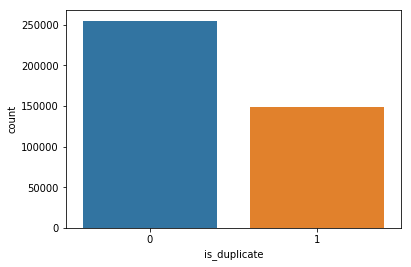

In [18]:
#countplot for 0 and 1
sns.countplot(data['is_duplicate'])

In [19]:
#total no of datapoint
print("Total no of datapoints are :", len(data))

Total no of datapoints are : 404287


In [20]:
#total no of questions
print("Total no of questions are :", len(data['question1'])*2)

Total no of questions are : 808574


In [21]:
#total no of unique questions in qid1
print(len(data['qid1'].unique()))
print(len(data['qid2'].unique()))
print(len(data['question1'].unique()))
print(len(data['question2'].unique()))

290652
299362
290455
299173


In [22]:
data_0 = (data['is_duplicate'].value_counts()[0]/ (data['is_duplicate'].value_counts()[0]+data['is_duplicate'].value_counts()[1]))*100
print("Percentage of dissimilar ques are:", data_0)
data_1 = (data['is_duplicate'].value_counts()[1]/ (data['is_duplicate'].value_counts()[0]+data['is_duplicate'].value_counts()[1]))*100
print("Percentage of similar ques are:", data_1)

Percentage of dissimilar ques are: 63.0799407351708
Percentage of similar ques are: 36.92005926482919


In [23]:
#Total unique questions in Qid1 and Qid2 is 
total_ques = list(data['question1'])+list(data['question2'])
print(len(total_ques))
print("Total distinct ques are:",len(set(total_ques)))
print("Percentage unique ques in set1 and set2 is",(len(set(total_ques))/len(total_ques))*100)

808574
Total distinct ques are: 537359
Percentage unique ques in set1 and set2 is 66.45761550581642


In [24]:
#Questions that occured more than one time in Question1 and Question2
print(len(data.question1.value_counts()[data['question1'].value_counts()>1]))
print(len(data.question2.value_counts()[data['question2'].value_counts()>1]))

54131
45663


In [25]:
print((data['question1'].value_counts()>1).value_counts())
print((data['question2'].value_counts()>1).value_counts())

False    236324
True      54131
Name: question1, dtype: int64
False    253510
True      45663
Name: question2, dtype: int64


In [26]:
#No of questions that occured more than one time
total_unique_ques = set(total_ques)
len(total_unique_ques)
total_ques= pd.Series(total_ques)
print('Total unique questions in Q1 and Q2 is',len(total_unique_ques))
print('Questions that occured more than one time is',len(total_ques.value_counts()[total_ques.value_counts()>1]))

#Question that appeared max times is 
print(total_ques.value_counts()[0])
total_ques.value_counts().index[0]

Total unique questions in Q1 and Q2 is 537359
Questions that occured more than one time is 111870
161


'What are the best ways to lose weight?'

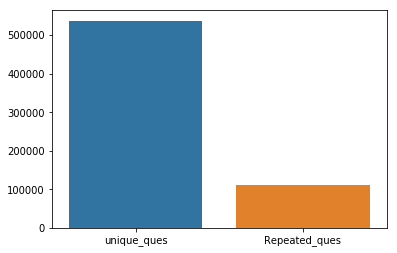

In [27]:
x= ['unique_ques', 'Repeated_ques']
y= [len(total_unique_ques), len(total_ques.value_counts()[total_ques.value_counts()>1])]
plt.figure(figsize=(6,4))
sns.barplot(x, y)
plt.show()

In [28]:
data_grp = data[['question1', 'question2', 'is_duplicate']].groupby(['is_duplicate'])
data_grp.describe()

question1                                                      \
                 count  unique                                    top freq   
is_duplicate                                                                 
0               255024  212769            What are cultural faux pas?   23   
1               149263   86169  How do I improve my English speaking?   50   

             question2          \
                 count  unique   
is_duplicate                     
0               255024  221129   
1               149263   86073   

                                                                      
                                                            top freq  
is_duplicate                                                          
0             How can you look at someone's private Instagra...  120  
1                                     How should I lose weight?   52

In [29]:
#Pair duplicates
data.duplicated(subset=['question1','question2']).value_counts()

False    404287
dtype: int64

In [30]:
pair_duplicates= data[['question1', 'question2', 'is_duplicate']].groupby(by=['question1', 'question2']).count()
print(pair_duplicates.shape)
print("No of duplicate questions:", pair_duplicates.shape[0]-data.shape[0])
pair_duplicates

(404287, 1)
No of duplicate questions: 0


,,is_duplicate
question1,question2,
Can I pay with a debit card on PayPal?,Can you transfer PayPal funds onto a debit card/credit card?,1
Does New York state have a flagship university?,How can the New York state be fixed?,1
Failures haunt me all the time.How do I cope up?,What can help me cope up with my failure?,1
"How do I make the time lapse images using an EOS 70D, with an intervalometer?",How do I make time-lapse photography?,1
"I didn't file a police report for a car accident that happened over a month ago. My insurance company won't pay for damage, what do I do?",Why don't I get the money I paid for a year worth of car insurance if I didn't get into any accident that year?,1
I have an offer from Manchester for mechatronics engineering and from Southampton for electromechanical. Which should I choose?,Are the Universities of Manchester and Southampton reputed for Mechanical Engineering (Globally)?,1
I'm openly gay and falling in love with my best friend I've known for 5 years he's a really great guy but I'm stuck. What should I do?,I'm in love with my best friend. I'm gay; he's straight. What should I do?,1
Politics of Tamil Nadu: How did 'Gopalasamy' become 'Vaiko'?,Why isn't Vaiko successful in Tamil Nadu politics?,1
The Mortal Instruments (book series): Will Jace and clary get married?,The Mortal Instruments (book series): What is the ship name for Mark Blackthorn and Kieran?,1


In [31]:
#Checking if there is any repeated pair of questions
data.loc[data['question1']==data['question2']]

,id,qid1,qid2,question1,question2,is_duplicate


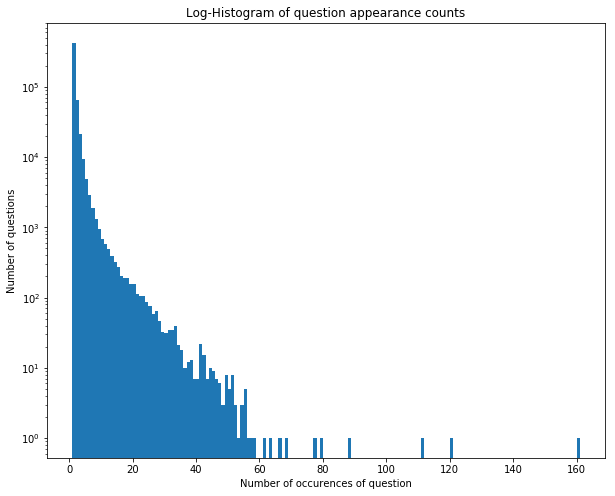

Max no of times one question occured is 161


In [32]:
#No of occurances of each ques
plt.figure(figsize=(10,8))
plt.hist(total_ques.value_counts().values, bins = 160)
plt.yscale("log")
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

print('Max no of times one question occured is', total_ques.value_counts()[0])

In [33]:
#Checking for null values and filling it with " "
ques1_null = data.loc[data['question1'].isna()==True]
ques1_null

,id,qid1,qid2,question1,question2,is_duplicate


In [34]:
#Checking for null values and filling it with " "
ques2_null = data.loc[data['question2'].isna()==True]
ques2_null

,id,qid1,qid2,question1,question2,is_duplicate


# Basis Feature Exctraction (Before Cleaning)
 - ____freq_qid1____ = Frequency of qid1's (how many times a ques is present in Question1 column)
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [35]:
data['freq_qid1'] = data.groupby(by='question1')['question1'].transform('count')
data['freq_qid2'] = data.groupby(by='question2')['question2'].transform('count')

data['q1len'] = data['question1'].apply(len)
data['q2len'] = data['question2'].apply(len)

data['q1_n_words'] = data['question1'].apply(lambda x : len(x.split()))
data['q2_n_words'] = data['question2'].apply(lambda x : len(x.split()))

def word_common(question1, question2):
    count = 0
    for i in question1.split():
        if i in question2.split():
            count = count+1
        else:
            pass
    return count
    

data['word_common'] = data.apply(lambda x : word_common(x['question1'], x['question2']), axis = 1)
data['word_total'] = data.apply(lambda x : len(x['question1'])+ len(x['question2']), axis=1)

In [36]:
data['word_share'] = data['word_common']/data['word_total']
data['sum_freq'] = data['freq_qid1'] + data['freq_qid2']
data['diff_freq'] = np.abs(data['freq_qid1'] - data['freq_qid2'])

In [37]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,sum_freq,diff_freq
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,12,123,0.097561,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,139,0.028777,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,132,0.022727,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,115,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,115,0.017391,4,2


In [38]:
#Analysis of newly created features
data.loc[data['question1']=='What is the story of Kohinoor (Koh-i-Noor) Diamond?']

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,sum_freq,diff_freq
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,139,0.028777,5,3
184732,184732,3,282170,What is the story of Kohinoor (Koh-i-Noor) Dia...,Is it possible to melt down diamonds?,0,4,1,51,37,8,7,0,88,0.000000,5,3
263614,263614,3,380197,What is the story of Kohinoor (Koh-i-Noor) Dia...,What are some interesting facts about Kohinoor...,0,4,1,51,55,8,8,2,106,0.018868,5,3
359232,359232,3,488853,What is the story of Kohinoor (Koh-i-Noor) Dia...,Could India keep the Koh-I-Noor safe?,0,4,1,51,37,8,6,1,88,0.011364,5,3


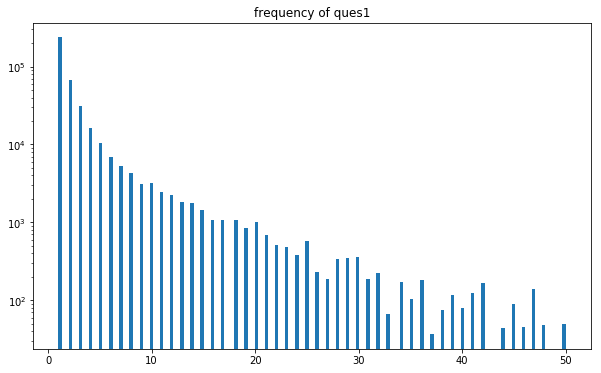

In [39]:
#Analysis of newly created feature
plt.figure(figsize=(10,6))
plt.hist(data['freq_qid1'], bins=150)
plt.yscale('log')
plt.title('frequency of ques1')
plt.show()

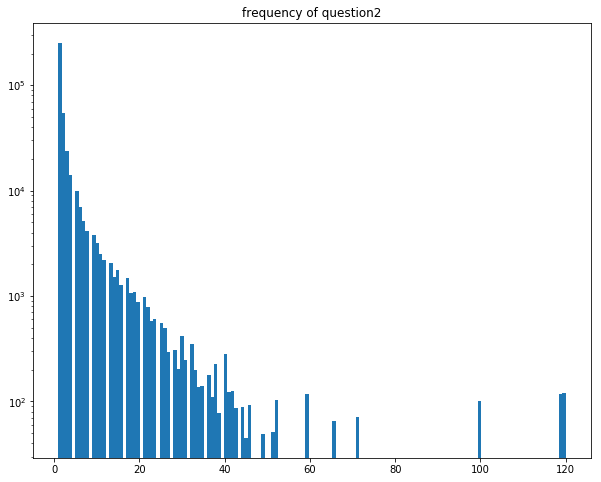

In [40]:
plt.figure(figsize=(10,8))
plt.hist(data['freq_qid2'], bins = 150)
plt.yscale("log")
plt.title("frequency of question2")
plt.show()

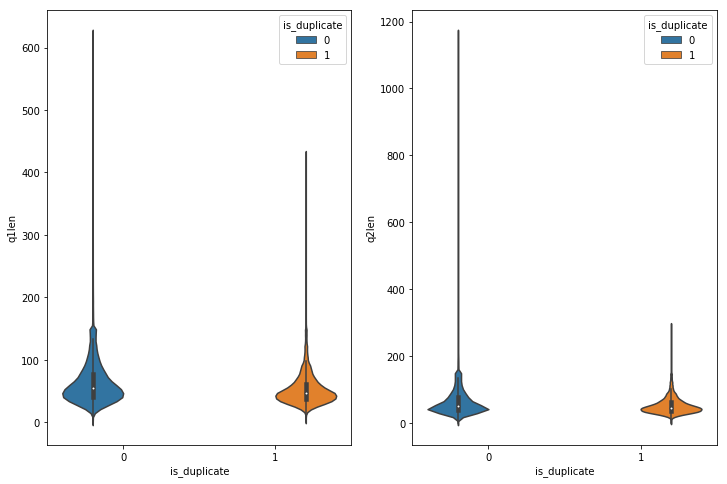

In [41]:
#Analysis of q1len and q2len
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(y = data['q1len'], x = data['is_duplicate'], hue=data['is_duplicate'])

plt.subplot(122)
sns.violinplot(y = data['q2len'], x = data['is_duplicate'], hue=data['is_duplicate'])

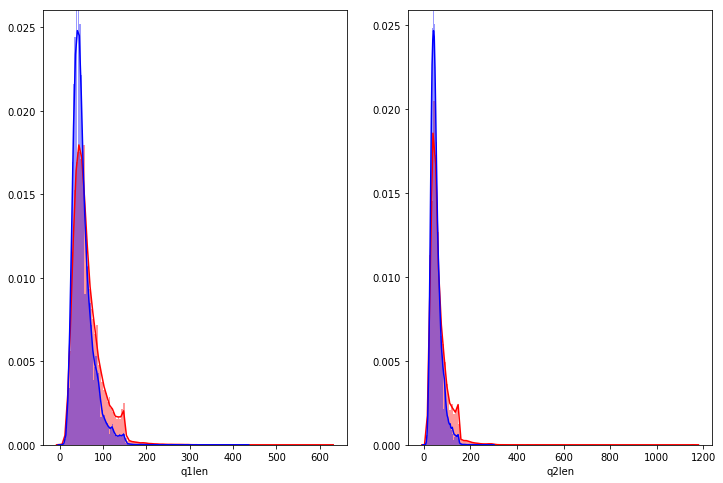

In [42]:
#Analysis of q1len and q2len
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.distplot(data[data['is_duplicate']==0]['q1len'], color = 'red', bins = 150)
sns.distplot(data[data['is_duplicate']==1]['q1len'], color = 'blue', bins = 150)

plt.subplot(122)
sns.distplot(data[data['is_duplicate']==0]['q2len'], color = 'red', bins = 150)
sns.distplot(data[data['is_duplicate']==1]['q2len'], color = 'blue', bins = 150)

In [43]:
print(data.groupby(by = 'is_duplicate')['q1len', 'q2len'].describe())

#The mean word length for non duplicate ques is 63 and 64 in q1 and q2. The mean word length for duplicate ques is 52. 

                 q1len                                                      \
                 count       mean        std  min   25%   50%   75%    max   
is_duplicate                                                                 
0             255024.0  63.455894  32.584002  1.0  41.0  55.0  78.0  623.0   
1             149263.0  52.841347  23.301917  3.0  37.0  47.0  62.0  430.0   

                 q2len                                                       
                 count       mean        std  min   25%   50%   75%     max  
is_duplicate                                                                 
0             255024.0  64.304787  38.116650  1.0  40.0  53.0  78.0  1169.0  
1             149263.0  52.938933  23.285384  2.0  37.0  47.0  63.0   295.0  


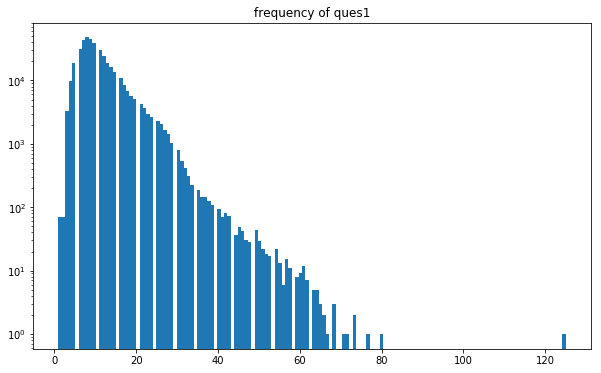

In [44]:
#Analysis of q1_n_words
plt.figure(figsize=(10,6))
plt.hist(data['q1_n_words'], bins=150)
plt.yscale('log')
plt.title('frequency of ques1')
plt.show()

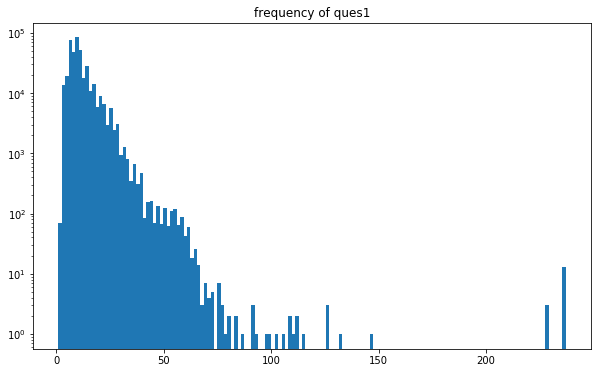

In [45]:
plt.figure(figsize=(10,6))
plt.hist(data['q2_n_words'], bins=150)
plt.yscale('log')
plt.title('frequency of ques1')
plt.show()

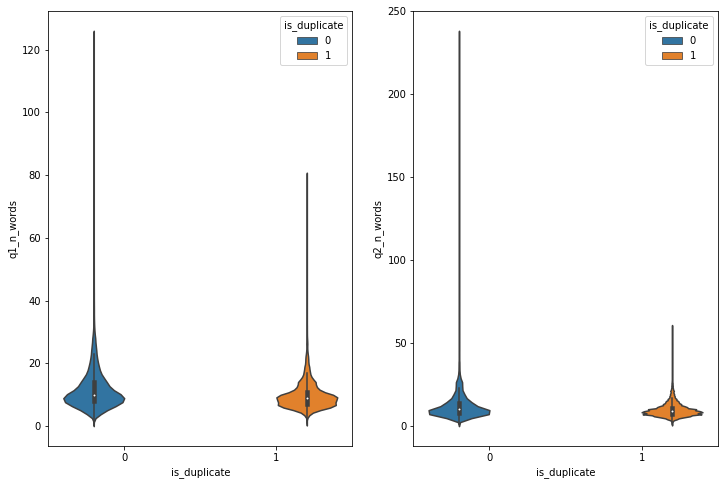

In [46]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.violinplot(x= data['is_duplicate'], y = data['q1_n_words'], hue=data['is_duplicate'])

plt.subplot(122)
sns.violinplot(x= data['is_duplicate'], y = data['q2_n_words'], hue=data['is_duplicate'])

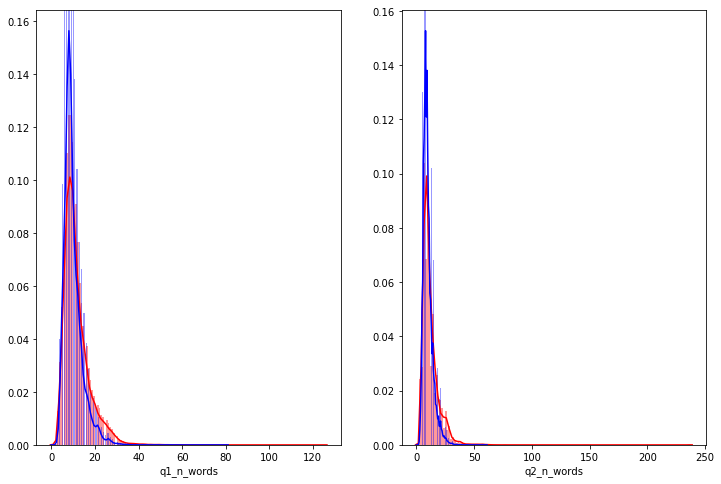

In [47]:
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.distplot(data[data['is_duplicate']==0]['q1_n_words'], color = 'red', bins = 150)
sns.distplot(data[data['is_duplicate']==1]['q1_n_words'], color = 'blue', bins = 150)

plt.subplot(122)
sns.distplot(data[data['is_duplicate']==0]['q2_n_words'], color = 'red', bins = 150)
sns.distplot(data[data['is_duplicate']==1]['q2_n_words'], color = 'blue', bins = 150)

In [48]:
print(data.groupby(by='is_duplicate')['q1_n_words', 'q2_n_words'].describe())

             q1_n_words                                                    \
                  count       mean       std  min  25%   50%   75%    max   
is_duplicate                                                                
0              255024.0  11.582910  5.955489  1.0  8.0  10.0  14.0  125.0   
1              149263.0   9.847665  4.162756  1.0  7.0   9.0  11.0   80.0   

             q2_n_words                                                    
                  count       mean       std  min  25%   50%   75%    max  
is_duplicate                                                               
0              255024.0  11.955781  7.161966  1.0  8.0  10.0  14.0  237.0  
1              149263.0   9.859999  4.155931  1.0  7.0   9.0  11.0   60.0  


In [49]:
#WordCommon
data.groupby('is_duplicate')['word_common'].describe()

,count,mean,std,min,25%,50%,75%,max
is_duplicate,,,,,,,,
0,255024.0,4.032585,3.535105,0.0,2.0,3.0,6.0,50.0
1,149263.0,5.445529,3.083104,0.0,3.0,5.0,7.0,52.0


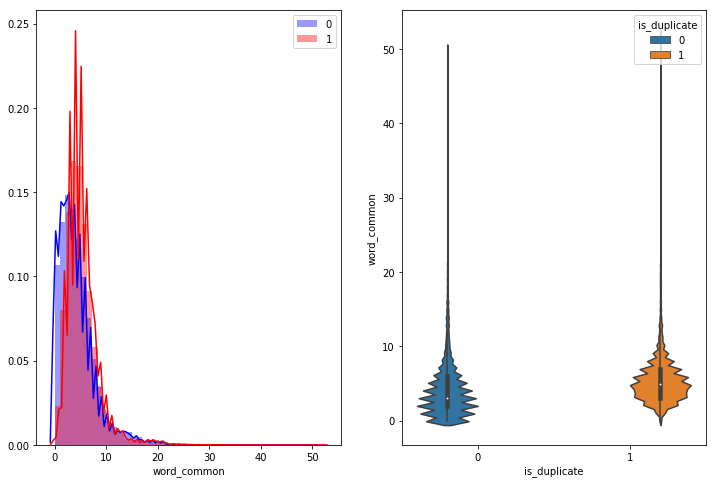

In [50]:
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.distplot(data[data['is_duplicate']==0]['word_common'], color='blue', label = "0")
sns.distplot(data[data['is_duplicate']==1]['word_common'], color='red', label = "1")
plt.legend()

plt.subplot(122)
sns.violinplot(x='is_duplicate', y = data['word_common'], hue= data['is_duplicate'], data= data)

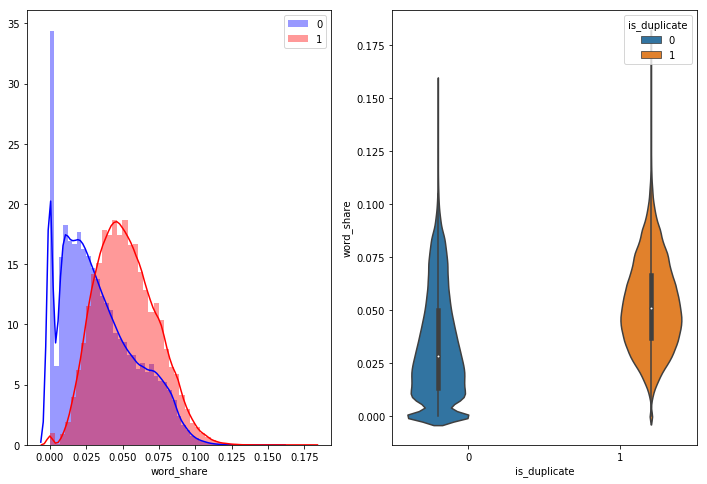

In [51]:
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.distplot(data[data['is_duplicate']==0]['word_share'], color='blue', label = "0")
sns.distplot(data[data['is_duplicate']==1]['word_share'], color='red', label = "1")
plt.legend()

plt.subplot(122)
sns.violinplot(x='is_duplicate', y = data['word_share'], hue= data['is_duplicate'], data= data)

In [52]:
#It means that word share is high in case of class1 and low in case of class 0
data.groupby(by='is_duplicate')['word_share'].describe()

,count,mean,std,min,25%,50%,75%,max
is_duplicate,,,,,,,,
0,255024.0,0.033391,0.024976,0.0,0.013514,0.028571,0.050000,0.155556
1,149263.0,0.052448,0.020712,0.0,0.037037,0.050847,0.066667,0.178295


In [53]:
#Advanced Feature Engineering

#Text Preprocessing
#1.HTML tags and http link removal
#2.Loweing of sentences
#3.removal of non english characters
#4.removal of punctuations

#I will not do stopword removal and lemmatization and stemming
#5.stopword removal
#6.lemmatization
#7.Stemming

In [54]:
df = data[0:10000].copy()
df['is_duplicate'].value_counts()

0    6289
1    3711
Name: is_duplicate, dtype: int64

In [55]:
def html_tag(x):
    if bool(re.search(r'<.+>', x))==True:
        return 'Yes'
    else:
        return "No"

def http_link(x):
    if bool(re.search(r'http', x))==True:
        return "Yes"
    else:
        return "No"
    
def html_tag_http_link_removal(x):
    import bs4
    soup = bs4.BeautifulSoup(x, "html.parser")
    x = soup.get_text()
    x = re.sub(r'http:\S+', " ", x)
    x = re.sub(r'\n', " ", x)
    
    return x

In [56]:
def unusual_txt(x):
    x = (re.sub(r'[^A-Za-z]+'," ", x))
    return x 

In [57]:
#data cleaning
data['question1'] = data['question1'].apply(html_tag_http_link_removal)
data['question2'] = data['question2'].apply(html_tag_http_link_removal)

data['question1'] = data['question1'].apply(lambda x : x.lower())
data['question2'] = data['question2'].apply(lambda x : x.lower())

data['question1'] = data['question1'].apply(lambda x : " ".join([i for i in x.split() if len(i)>2]))
data['question2'] = data['question2'].apply(lambda x : " ".join([i for i in x.split() if len(i)>2]))

data['question1'] = data['question1'].apply(lambda x : re.sub(r'[^a-z]+', " ", x))
data['question2'] = data['question2'].apply(lambda x : re.sub(r'[^a-z]+', " ", x))


C:\python\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [58]:
#Checking and droping the blank rows 

data.loc[(data['question1']=="")|(data['question1']==" ")]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,sum_freq,diff_freq
3306,3306,6553,6554,,why cornell s endowment the lowest the ivy lea...,0,1,1,1,56,1,10,0,57,0.000000,2,0
13016,13016,25026,25027,,why should one not work google,0,11,2,1,34,1,7,0,35,0.000000,13,9
20794,20794,39204,39205,,what the gmail tech support help phone number,0,11,1,1,49,1,9,0,50,0.000000,12,10
23884,23884,44699,44700,,what hh,0,1,1,2,11,1,3,0,13,0.000000,2,0
28609,28609,53033,53034,,,0,1,1,31,33,3,4,1,64,0.015625,2,0
31239,31239,57607,57608,,what math math,0,1,1,31,49,3,3,0,80,0.000000,2,0
44619,44619,80055,80056,,how activate reliance jio g,0,1,3,2,34,1,7,0,36,0.000000,4,2
96725,96725,161071,161072,,who are moses noah and exodus,0,11,1,1,31,1,6,0,32,0.000000,12,10
102512,102512,169595,169596,,first year university and find hard read exams...,0,1,1,4,166,2,36,0,170,0.000000,2,0
104101,104101,171925,171926,,problem solving problem not problem but when p...,0,11,1,1,149,1,29,0,150,0.000000,12,10


In [59]:
data.loc[(data['question2']=="")|(data['question2']==" ")]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,sum_freq,diff_freq
13797,13797,26463,26464,what the most visited tourist attraction africa,,0,1,1,54,70,9,13,0,124,0.000000,2,0
20072,20072,37898,37899,how could solve this,,0,2,2,23,6,5,1,0,29,0.000000,4,0
28609,28609,53033,53034,,,0,1,1,31,33,3,4,1,64,0.015625,2,0
34755,34755,63631,63632,single double triple quadruple what are etc ca...,,0,7,1,87,39,21,14,4,126,0.031746,8,6
43406,43406,78081,53033,java file the directory x src and class file ...,,0,1,1,134,31,27,3,0,165,0.000000,2,0
47056,47056,84067,84068,there anywhere the world offering pain managem...,,0,3,1,117,1,19,1,0,118,0.000000,4,2
90492,90492,151837,151838,from which website can download pornography sa...,,0,1,1,63,36,10,7,0,99,0.000000,2,0
109009,109009,178981,178982,how make box that can put phone when don t wan...,,0,2,1,113,2,25,1,0,115,0.000000,3,1
144343,144343,228468,228469,what the psychological explanation the existen...,,0,1,1,92,44,16,10,0,136,0.000000,2,0
175282,175282,269923,44699,,,1,1,1,3,2,1,1,0,5,0.000000,2,0


In [60]:
blank_index1 = data.loc[(data['question1']=="")|(data['question1']==" ")].index
blank_index2 = data.loc[(data['question2']=="")|(data['question2']==" ")].index
blank_index = list(blank_index1)+list(blank_index2)
data.drop(index=blank_index, inplace= True)

# Advanced feature extraction (NLP and Fuzzy features)
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>

- __fuzz_ratio__
<br>
<br>

- __partial_fuzz_ratio__
<br>
<br>

- __token_sort_ratio__
<br>
<br>

- __token_set_ratio__
<br>
<br>

In [61]:
def cwc_min(ques1, ques2):
    count = 0
    for i in ques1.split():
        if i in ques2.split():
            count = count + 1
    return count/min(len(ques1.split()), len(ques2.split()))

def cwc_max(ques1, ques2):
    count = 0
    for i in ques1.split():
        if i in ques2.split():
            count = count + 1
    return count/max(len(ques1.split()), len(ques2.split()))

def last_word_equal(ques1, ques2):
    if ((ques1.split())[-1]==(ques2.split())[-1]):
        return 1
    else:
        return 0
    
def abs_len_diff(ques1, ques2):
    return abs(len(ques1.split())-len(ques2.split()))

def mean_len(ques1, ques2):
    return (len(ques1.split())+len(ques2.split()))/2

In [62]:
data['cwc_min'] = data.apply(lambda x : cwc_min(x['question1'], x['question2']), axis = 1)

data['cwc_max'] = data.apply(lambda x : cwc_max(x['question1'], x['question2']), axis = 1)

data['last_word_equal'] = data.apply(lambda x : last_word_equal(x['question1'], x['question2']), axis = 1)

data['abs_len_diff'] = data.apply(lambda x : abs_len_diff(x['question1'], x['question2']), axis = 1)

data['mean_len'] = data.apply(lambda x : mean_len(x['question1'], x['question2']), axis = 1)

In [63]:
#creating fuzzyfeatures - All thee values can be thought of similarity. if the values lie as 100 then they both are similar.
import warnings
warnings.filterwarnings('ignore')
from fuzzywuzzy import fuzz

data['fuzz_ratio']= data.apply(lambda x : fuzz.QRatio(x['question1'], x['question2']), axis=1)

data['partial_fuzz_ratio']= data.apply(lambda x : fuzz.partial_ratio(x['question1'], x['question2']), axis=1)

data['token_sort_ratio']= data.apply(lambda x : fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)

data['token_set_ratio']= data.apply(lambda x : fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)

In [64]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,diff_freq,cwc_min,cwc_max,last_word_equal,abs_len_diff,mean_len,fuzz_ratio,partial_fuzz_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what the step step guide invest share market i...,what the step step guide invest share market,0,1,1,66,57,...,0,1.000,0.888889,0,1,8.5,94,100,94,100
1,1,3,4,what the story kohinoor koh i noor diamond,what would happen the indian government stole ...,0,4,1,51,88,...,3,0.875,0.500000,0,6,11.0,65,79,65,92
2,2,5,6,how can increase the speed internet connection...,how can internet speed increased hacking throu...,0,1,1,73,59,...,0,0.500,0.400000,0,2,9.0,54,47,70,70
3,3,7,8,why mentally very lonely how can solve it,find the remainder when math math divided,0,1,1,50,65,...,0,0.000,0.000000,0,1,7.5,12,18,24,26
4,4,9,10,which one dissolve water quikly sugar salt met...,which fish would survive salt water,0,3,1,76,39,...,2,0.500,0.272727,0,5,8.5,33,53,47,63


In [65]:
#Analysis of the newly created features
#cwc_min
data.groupby(by='is_duplicate')['cwc_min'].describe()

,count,mean,std,min,25%,50%,75%,max
is_duplicate,,,,,,,,
0,254973.0,0.505108,0.300660,0.0,0.285714,0.50,0.750000,4.6
1,149262.0,0.725162,0.208694,0.0,0.571429,0.75,0.857143,3.0


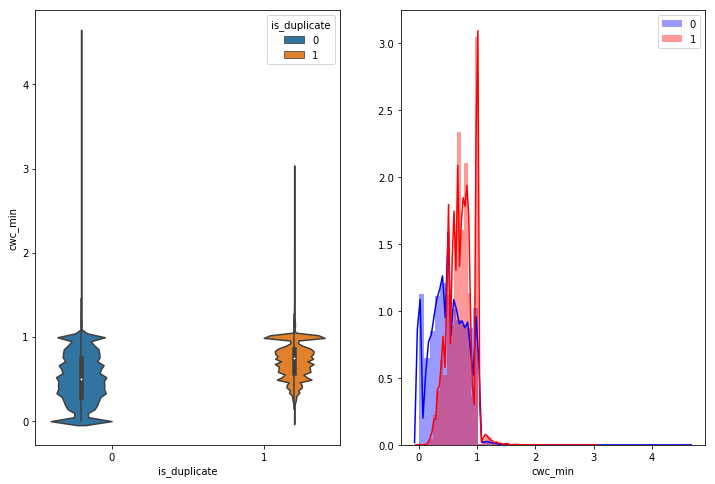

In [66]:
#cwc_min
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x= data['is_duplicate'], y= data['cwc_min'], hue=data['is_duplicate'])

plt.subplot(122)
sns.distplot(data.loc[data['is_duplicate']==0]['cwc_min'], color = 'blue', label="0")
sns.distplot(data.loc[data['is_duplicate']==1]['cwc_min'], color = 'red', label="1")
plt.legend()
plt.show()

In [67]:
#cwc_max
data.groupby(by='is_duplicate')['cwc_max'].describe()

,count,mean,std,min,25%,50%,75%,max
is_duplicate,,,,,,,,
0,254973.0,0.377677,0.261733,0.0,0.172414,0.333333,0.571429,1.0
1,149262.0,0.568894,0.196721,0.0,0.428571,0.571429,0.714286,1.0


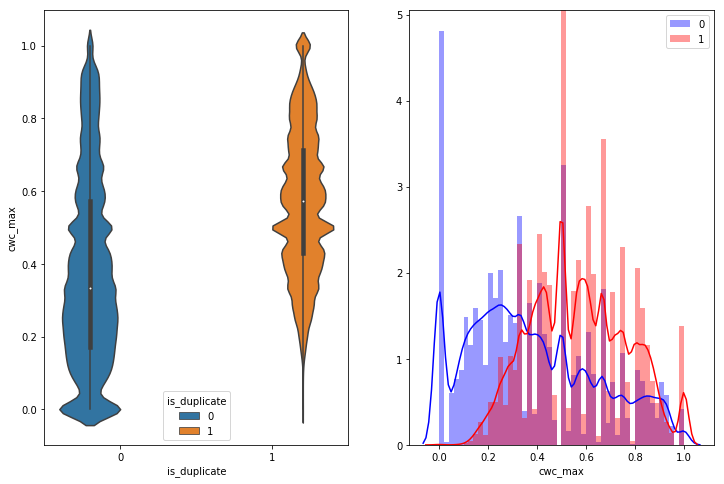

In [68]:
#cwc_max
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x= data['is_duplicate'], y= data['cwc_max'], hue=data['is_duplicate'])

plt.subplot(122)
sns.distplot(data.loc[data['is_duplicate']==0]['cwc_max'], color = 'blue', label="0")
sns.distplot(data.loc[data['is_duplicate']==1]['cwc_max'], color = 'red', label="1")
plt.legend()
plt.show()

In [69]:
#Last_word_equal
print(data.loc[data['is_duplicate']==0]['last_word_equal'].value_counts())

print(data.loc[data['is_duplicate']==1]['last_word_equal'].value_counts())

0    200078
1     54895
Name: last_word_equal, dtype: int64
1    75064
0    74198
Name: last_word_equal, dtype: int64


In [70]:
data.groupby(by='is_duplicate')['last_word_equal'].value_counts()

is_duplicate  last_word_equal
0             0                  200078
              1                   54895
1             1                   75064
              0                   74198
Name: last_word_equal, dtype: int64

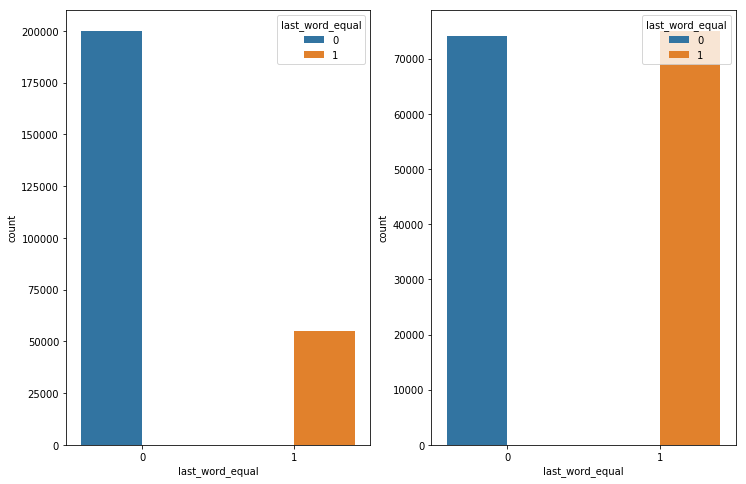

In [71]:
plt.figure(figsize = (12,8))
plt.subplot(121)
sns.countplot(data.loc[data['is_duplicate']==0]['last_word_equal'], hue=data['last_word_equal'])

plt.subplot(122)
sns.countplot(data.loc[data['is_duplicate']==1]['last_word_equal'], hue=data['last_word_equal'])

In [72]:
#Absolute_len_diff
data.groupby(by='is_duplicate')['abs_len_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
is_duplicate,,,,,,,,
0,254973.0,3.525099,4.305514,0.0,1.0,2.0,5.0,170.0
1,149262.0,2.017566,2.147410,0.0,1.0,1.0,3.0,31.0


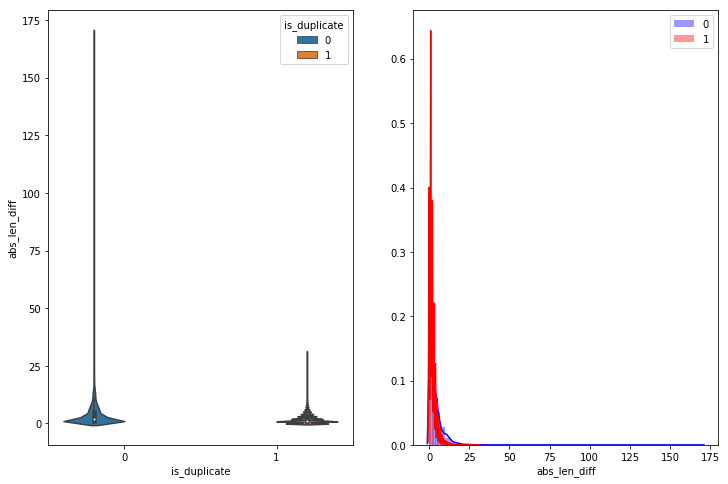

In [73]:
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x= data['is_duplicate'], y= data['abs_len_diff'], hue=data['is_duplicate'])

plt.subplot(122)
sns.distplot(data.loc[data['is_duplicate']==0]['abs_len_diff'], color = 'blue', label="0")
sns.distplot(data.loc[data['is_duplicate']==1]['abs_len_diff'], color = 'red', label="1")
plt.legend()
plt.show()

In [74]:
#mean_len
data.groupby(by='is_duplicate')['mean_len'].describe()

,count,mean,std,min,25%,50%,75%,max
is_duplicate,,,,,,,,
0,254973.0,9.225634,4.297233,1.0,6.5,8.5,11.0,101.5
1,149262.0,7.743103,3.028410,1.0,5.5,7.0,9.0,47.0


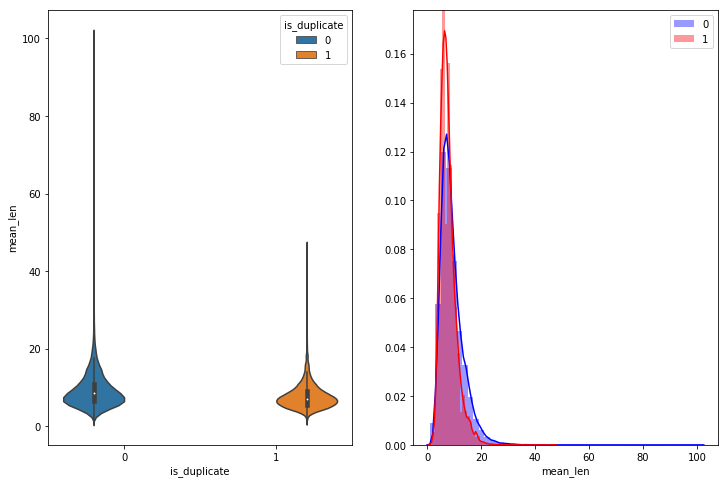

In [75]:
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x= data['is_duplicate'], y= data['mean_len'], hue=data['is_duplicate'])

plt.subplot(122)
sns.distplot(data.loc[data['is_duplicate']==0]['mean_len'], color = 'blue', label="0")
sns.distplot(data.loc[data['is_duplicate']==1]['mean_len'], color = 'red', label="1")
plt.legend()
plt.show()

In [76]:
#fuzz_ratio
data.groupby(by='is_duplicate')['fuzz_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
is_duplicate,,,,,,,,
0,254973.0,52.469089,22.147928,0.0,35.0,50.0,70.0,100.0
1,149262.0,69.882167,16.230650,2.0,58.0,70.0,83.0,100.0


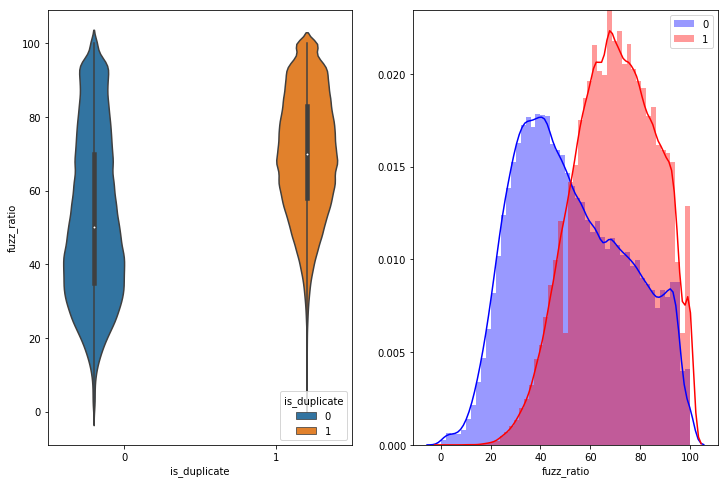

In [77]:
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x= data['is_duplicate'], y= data['fuzz_ratio'], hue=data['is_duplicate'])

plt.subplot(122)
sns.distplot(data.loc[data['is_duplicate']==0]['fuzz_ratio'], color = 'blue', label="0")
sns.distplot(data.loc[data['is_duplicate']==1]['fuzz_ratio'], color = 'red', label="1")
plt.legend()
plt.show()

In [78]:
#partial_fuzz_ratio
data.groupby(by='is_duplicate')['partial_fuzz_ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
is_duplicate,,,,,,,,
0,254973.0,60.456433,19.415922,6.0,45.0,59.0,76.0,100.0
1,149262.0,74.463467,14.101444,15.0,64.0,75.0,85.0,100.0


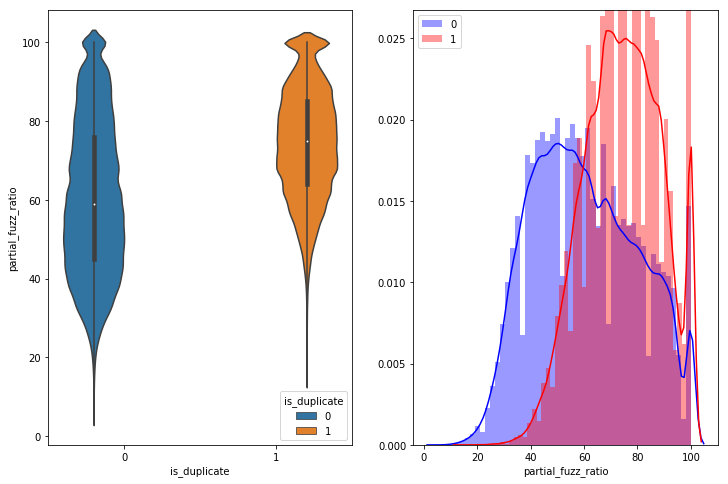

In [79]:
plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x= data['is_duplicate'], y= data['partial_fuzz_ratio'], hue=data['is_duplicate'])

plt.subplot(122)
sns.distplot(data.loc[data['is_duplicate']==0]['partial_fuzz_ratio'], color = 'blue', label="0")
sns.distplot(data.loc[data['is_duplicate']==1]['partial_fuzz_ratio'], color = 'red', label="1")
plt.legend()
plt.show()

                 count       mean        std  min   25%   50%   75%    max
is_duplicate                                                              
0             254973.0  56.311472  19.905806  0.0  42.0  55.0  71.0  100.0
1             149262.0  71.972277  14.708900  5.0  61.0  72.0  83.0  100.0


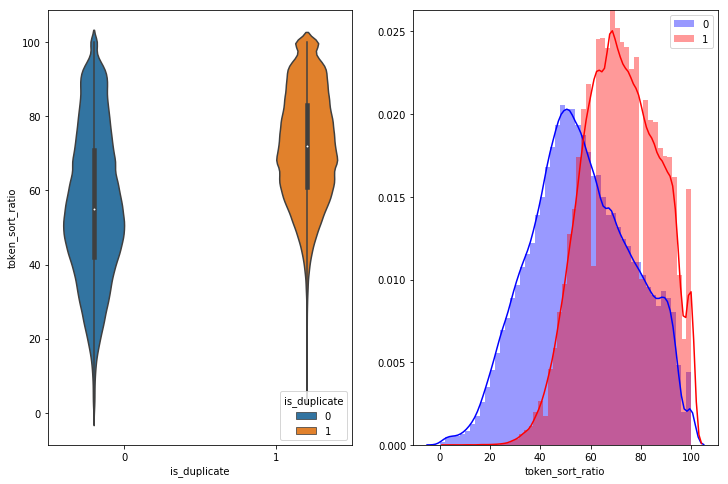

In [80]:
#token_sort_ratio
print(data.groupby(by='is_duplicate')['token_sort_ratio'].describe())

plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x= data['is_duplicate'], y= data['token_sort_ratio'], hue=data['is_duplicate'])

plt.subplot(122)
sns.distplot(data.loc[data['is_duplicate']==0]['token_sort_ratio'], color = 'blue', label="0", )
sns.distplot(data.loc[data['is_duplicate']==1]['token_sort_ratio'], color = 'red', label="1")
plt.legend()
plt.show()

                 count      mean        std   min   25%   50%   75%    max
is_duplicate                                                              
0             254973.0  65.29200  22.526947   0.0  49.0  66.0  84.0  100.0
1             149262.0  83.14297  13.345377  12.0  74.0  85.0  94.0  100.0


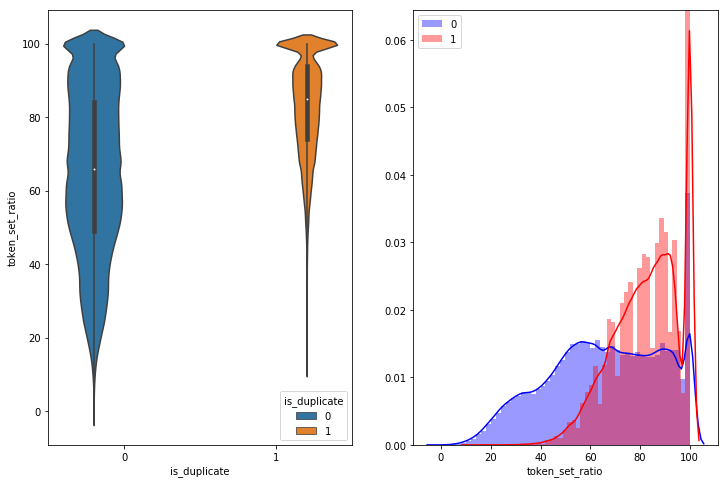

In [81]:
#token_set_ratio
print(data.groupby(by='is_duplicate')['token_set_ratio'].describe())

plt.figure(figsize=(12,8))

plt.subplot(121)
sns.violinplot(x= data['is_duplicate'], y= data['token_set_ratio'], hue=data['is_duplicate'])

plt.subplot(122)
sns.distplot(data.loc[data['is_duplicate']==0]['token_set_ratio'], color = 'blue', label="0")
sns.distplot(data.loc[data['is_duplicate']==1]['token_set_ratio'], color = 'red', label="1")
plt.legend()
plt.show()

In [82]:
#Bivariate Analysis
data[['cwc_min', 'cwc_max', 'fuzz_ratio','partial_fuzz_ratio','token_sort_ratio', 'token_set_ratio']].corr(method='spearman')

,cwc_min,cwc_max,fuzz_ratio,partial_fuzz_ratio,token_sort_ratio,token_set_ratio
cwc_min,1.000000,0.880163,0.759677,0.795118,0.784377,0.941343
cwc_max,0.880163,1.000000,0.872270,0.780877,0.903610,0.874209
fuzz_ratio,0.759677,0.872270,1.000000,0.892353,0.909227,0.829173
partial_fuzz_ratio,0.795118,0.780877,0.892353,1.000000,0.812569,0.854148
token_sort_ratio,0.784377,0.903610,0.909227,0.812569,1.000000,0.866100
token_set_ratio,0.941343,0.874209,0.829173,0.854148,0.866100,1.000000


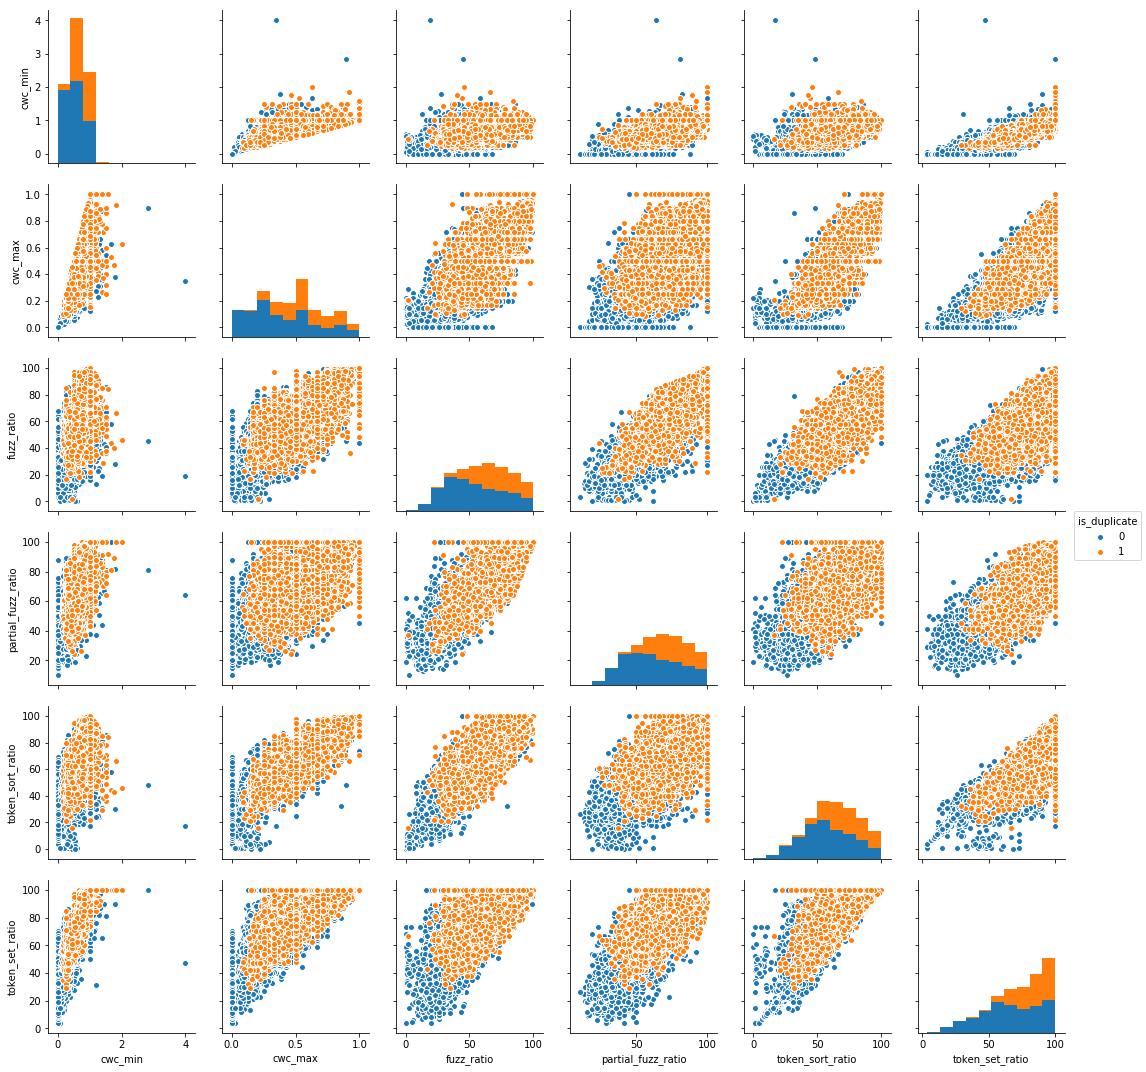

In [83]:
sns.pairplot(data[['cwc_min', 'cwc_max', 'fuzz_ratio','partial_fuzz_ratio','token_sort_ratio', 'token_set_ratio', 
'is_duplicate']][0:20000], hue='is_duplicate', vars=['cwc_min', 'cwc_max', 'fuzz_ratio','partial_fuzz_ratio','token_sort_ratio', 'token_set_ratio'])

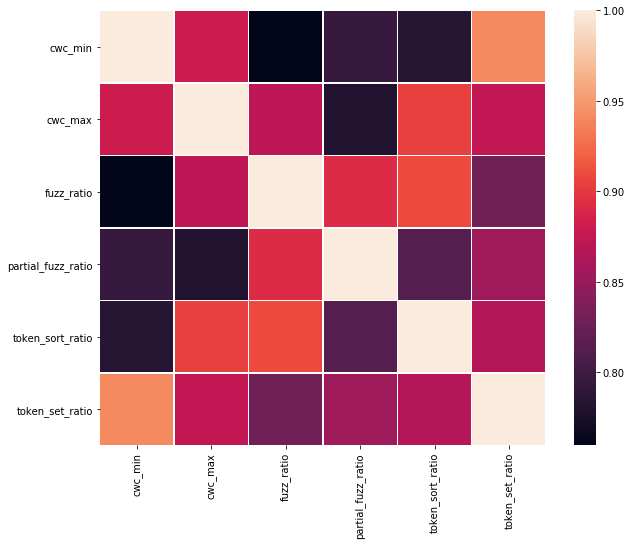

In [84]:
plt.figure(figsize=(10,8))
sns.heatmap(data[['cwc_min', 'cwc_max', 'fuzz_ratio','partial_fuzz_ratio','token_sort_ratio', 'token_set_ratio']].corr(method='spearman')
       , linewidths=0.5)

#Creating Wordcloud
#1-- Creating word cloud for non duplicate ques and duplicate ques pairs
#2-- Removing words that are more frequent

In [85]:
data_dup = data.loc[data['is_duplicate']==1]
data_nodup = data.loc[data['is_duplicate']==0]

In [86]:
print(data_dup.shape)
print(data_nodup.shape)

(149262, 26)
(254973, 26)


In [87]:
neg = np.hstack((data_dup['question1'], data_dup['question2'] ))
pos = np.hstack((data_nodup['question1'], data_nodup['question2'] ))

print("Total no of datapoints(questions) in class 0 that is duplicate", len(neg))
print("Total no of datapoints(questions) in class 1 that is not duplicate", len(pos))

#Saving the np array into a text file
np.savetxt('train_full_pos.txt', pos, delimiter=' ', fmt='%s')
np.savetxt('train__full_neg.txt', neg, delimiter=' ', fmt='%s')

Total no of datapoints(questions) in class 0 that is duplicate 298524
Total no of datapoints(questions) in class 1 that is not duplicate 509946


In [88]:
pos_text = " ".join(pos)
neg_text = " ".join(neg)

pos_words = pos_text.split()
neg_words = neg_text.split()

print ("Total number of words in duplicate pair questions :",len(pos_words))
print ("Total number of words in non duplicate pair questions :",len(neg_words))

Total number of words in duplicate pair questions : 4704575
Total number of words in non duplicate pair questions : 2311502


Word Cloud for non Duplicate Question pairs


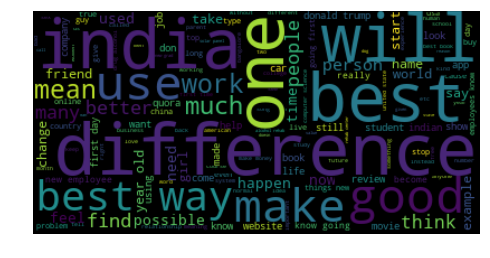

In [89]:
from wordcloud import WordCloud, STOPWORDS
wc= WordCloud()
wc.generate(pos_text) #wordcould need all the sentences to be passed as in input to generate the wrodcloud
print ("Word Cloud for non Duplicate Question pairs")
plt.figure(figsize=(8,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


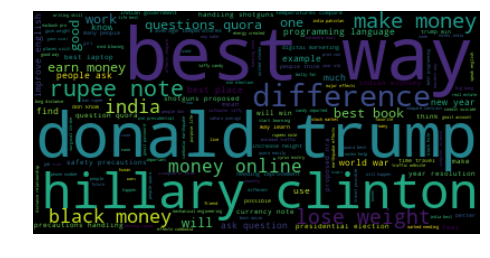

In [90]:
from wordcloud import WordCloud, STOPWORDS
wc= WordCloud()
wc.generate(neg_text) #wordcould need all the sentences to be passed as in input to generate the wrodcloud
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(8,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Modelling

In [91]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns=None
data.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,sum_freq,diff_freq,cwc_min,cwc_max,last_word_equal,abs_len_diff,mean_len,fuzz_ratio,partial_fuzz_ratio,token_sort_ratio,token_set_ratio
0,0,1,2,what the step step guide invest share market i...,what the step step guide invest share market,0,1,1,66,57,14,12,12,123,0.097561,2,0,1.0,0.888889,0,1,8.5,94,100,94,100


In [92]:
#Lets merge the q1 and q2 in a new column callled as question 
data['question'] = data['question1']+data['question2']
#Exporting the data csv
#data.to_csv(r'C:\Users\user-pc\AppliedAi\6.0\Quora Questions Pairs\processed_features_mine.csv')

In [1]:
import pandas as pd
data = pd.read_csv(r'C:\Users\user-pc\AppliedAi\6.0\Quora Questions Pairs\procesed_data_mine\processed_features_mine.csv')
data.shape

(404235, 28)

# Bag Of Word Featurization

In [2]:
#Lets create the Bag of words feature for q1 and q2 
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words="english", binary=True)
count_vect.fit(data['question'])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [3]:
print(count_vect.vocabulary_)

{'step': 68902, 'guide': 30383, 'invest': 36290, 'share': 65195, 'market': 43804, 'india': 34932, 'story': 69182, 'kohinoor': 39556, 'koh': 39553, 'noor': 49676, 'diamond': 19360, 'happen': 31084, 'indian': 34947, 'government': 29656, 'stole': 69103, 'increase': 34829, 'speed': 67948, 'internet': 36006, 'connection': 14984, 'using': 76707, 'vpn': 78321, 'increased': 34830, 'hacking': 30698, 'dns': 20510, 'mentally': 44961, 'lonely': 42091, 'solve': 67425, 'remainder': 60556, 'math': 44151, 'divided': 20384, 'dissolve': 20240, 'water': 78842, 'quikly': 58574, 'sugar': 69956, 'salt': 63023, 'methane': 45225, 'carbon': 10896, 'oxide': 52170, 'fish': 26184, 'survive': 70516, 'astrology': 4731, 'capricorn': 10835, 'sun': 70118, 'cap': 10763, 'moon': 46810, 'rising': 61817, 'does': 20578, 'say': 63586, 'triple': 74437, 'ascendant': 4379, 'buy': 10174, 'tiago': 72968, 'keeps': 38736, 'childern': 12489, 'active': 729, 'far': 25243, 'phone': 54458, 'video': 77688, 'games': 28098, 'good': 29496,

In [4]:
len(count_vect.get_feature_names())

81648

In [5]:
print(data['question'][100])
print("*"*100)
bow100 = count_vect.transform([data['question'][100]])
print(bow100)
print(bow100.shape)
print(count_vect.get_feature_names()[34932])

will there really any war between india and pakistan over the uri attack what will its effects will there nuclear war between india and pakistan 
****************************************************************************************************
  (0, 4939)	1
  (0, 22177)	1
  (0, 34932)	1
  (0, 50067)	1
  (0, 52427)	1
  (0, 59554)	1
  (0, 76589)	1
  (0, 78646)	1
(1, 81648)
india


In [6]:
#transform
bag_of_word = count_vect.transform(data['question'])
print(type(bag_of_word))
print(bag_of_word.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(404235, 81648)


In [7]:
print('Amount of non-zero occurances', bag_of_word.nnz)

Amount of non-zero occurances 3026213


In [8]:
#Sparcity
sparcity= (100*bag_of_word.nnz/(bag_of_word.shape[0]*bag_of_word.shape[1]))
print('sparcity= {}'.format(sparcity))

sparcity= 0.009168958945033459


#### Adding the 20 columns to bag of words 

In [10]:
#Adding the 20 columns to bag of words 
import numpy as np
from scipy import sparse
bow_data = sparse.hstack((bag_of_word, np.array(data.iloc[:, 6:26])))
print(bow_data.shape)
print(type(bow_data))

(404235, 81668)
<class 'scipy.sparse.coo.coo_matrix'>


# Linear regression on BOW data + 20 features

The log loss on train data is: 0.0030637899124505356
The log loss on test data is: 0.0031237542619785234
****************************************************************************************************
The accuracy score on train data is: 1.0
The accuracy score on test data is: 1.0
****************************************************************************************************


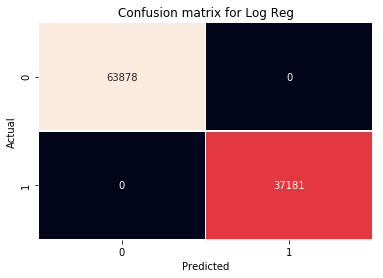

****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63878
           1       1.00      1.00      1.00     37181

    accuracy                           1.00    101059
   macro avg       1.00      1.00      1.00    101059
weighted avg       1.00      1.00      1.00    101059



In [15]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
import seaborn as sns
x_train, x_test, y_train, y_test = train_test_split(bow_data, data['is_duplicate'], test_size = 0.25, random_state = 1)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(class_weight="balanced", verbose=0)
log_reg.fit(x_train, y_train)
sig_cal = CalibratedClassifierCV(base_estimator=log_reg)
sig_cal.fit(x_train, y_train)

import seaborn as sns
y_pred_train = sig_cal.predict_proba(x_train)
y_pred_test = sig_cal.predict_proba(x_test)
print("The log loss on train data is:", log_loss(y_train, y_pred_train))
print("The log loss on test data is:", log_loss(y_test, y_pred_test))
print("*"*100)
print("The accuracy score on train data is:", accuracy_score(y_train, log_reg.predict(x_train)))
print("The accuracy score on test data is:", accuracy_score(y_test, log_reg.predict(x_test)))
print("*"*100)
sns.heatmap(confusion_matrix(y_test, log_reg.predict(x_test)), annot= True, fmt="d", linewidths=0.5, cbar=False)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix for Log Reg")
plt.show()
print("*"*100)
print(classification_report(y_test, log_reg.predict(x_test)))

# TFIDF Featurization

In [16]:
#Lets create the Tfidf feature for q1 and q2 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(stop_words="english")
tfidf = tfidf_vect.fit_transform(data['question'])
print(tfidf.shape)

(404235, 81648)


In [17]:
print('Amount of non-zero occurances', tfidf.nnz)

#Sparcity
sparcity= (100*bag_of_word.nnz/(bag_of_word.shape[0]*bag_of_word.shape[1]))
print('sparcity= {}'.format(sparcity))

#Adding the 20 columns to bag of words 
from scipy import sparse
tfidf_data = sparse.hstack((tfidf, np.array(data.iloc[:, 6:26])))
print(tfidf_data.shape)
print(type(tfidf_data))

Amount of non-zero occurances 3026213
sparcity= 0.009168958945033459
(404235, 81668)
<class 'scipy.sparse.coo.coo_matrix'>


# Linear regression on TFIDF data + 20 features

The log loss on train data is: 0.012431754417256132
The log loss on test data is: 0.012401784949519781
****************************************************************************************************
The accuracy score on train data is: 1.0
The accuracy score on test data is: 1.0
****************************************************************************************************


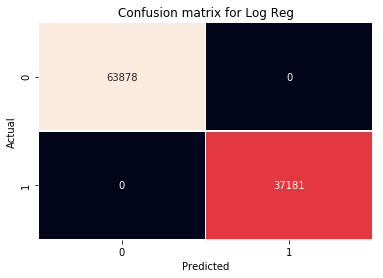

****************************************************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63878
           1       1.00      1.00      1.00     37181

    accuracy                           1.00    101059
   macro avg       1.00      1.00      1.00    101059
weighted avg       1.00      1.00      1.00    101059



In [18]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tfidf_data, data['is_duplicate'], test_size = 0.25, random_state = 1)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(class_weight="balanced", verbose=0)
log_reg.fit(x_train, y_train)

sig_cal = CalibratedClassifierCV(base_estimator=log_reg)
sig_cal.fit(x_train, y_train)

import seaborn as sns
y_pred_train = sig_cal.predict_proba(x_train)
y_pred_test = sig_cal.predict_proba(x_test)
print("The log loss on train data is:", log_loss(y_train, y_pred_train))
print("The log loss on test data is:", log_loss(y_test, y_pred_test))
print("*"*100)
print("The accuracy score on train data is:", accuracy_score(y_train, log_reg.predict(x_train)))
print("The accuracy score on test data is:", accuracy_score(y_test, log_reg.predict(x_test)))
print("*"*100)
sns.heatmap(confusion_matrix(y_test, log_reg.predict(x_test)), annot= True, fmt="d", linewidths=0.5, cbar=False)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix for Log Reg")
plt.show()
print("*"*100)
print(classification_report(y_test, log_reg.predict(x_test)))

# Word To Vec Model

In [105]:
#Featurizig text feature with average word2vec and Tfidf word2vec
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import sys
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec, KeyedVectors

In [106]:
#creating own W2V for the text - Here we are using Gensim W2V and creating our own W2V. 
#We are using whole set of questions (ques1 + ques2)
list_of_sent = []
for sen in tqdm(data['question']):
    list_of_sent.append(sen.split())

100%|███████████████████████████████| 404235/404235 [00:05<00:00, 79861.68it/s]


In [107]:
len(list_of_sent)
#W2V model
w2v = Word2Vec(list_of_sent, size=300, min_count=2, workers=4)

404235

In [108]:
words = w2v.wv.vocab
print(len(words))
print(w2v.wv.most_similar('what'))
print(w2v.wv.most_similar('india'))
print(w2v.wv.most_similar('trump'))

49688
[('the', 0.4977074861526489), ('which', 0.4693058729171753), ('succinct', 0.3154209554195404), ('poewr', 0.3122408092021942), ('vmax', 0.31171849370002747), ('embeddedwhat', 0.30860453844070435), ('transdisciplinarity', 0.30838918685913086), ('are', 0.30295735597610474), ('gantt', 0.2989616394042969), ('overfishing', 0.29635724425315857)]
[('pakistan', 0.5862435102462769), ('nepal', 0.5852081179618835), ('bangladesh', 0.5769436359405518), ('usa', 0.5488829612731934), ('china', 0.5243260264396667), ('bihar', 0.5070556998252869), ('indian', 0.5051560401916504), ('gujarat', 0.5047140717506409), ('dubai', 0.4744968116283417), ('singapore', 0.4712172746658325)]
[('trumps', 0.7618871927261353), ('hoffman', 0.7110682725906372), ('knuth', 0.7040284872055054), ('trumph', 0.6215341091156006), ('democrats', 0.5523726940155029), ('hillary', 0.5490673780441284), ('sicp', 0.534845769405365), ('obama', 0.5339507460594177), ('presidency', 0.49879997968673706), ('campaign', 0.4977092146873474)]


In [109]:
words_list = list(words)
print(words_list[0:20])

['what', 'the', 'step', 'guide', 'invest', 'share', 'market', 'india', 'story', 'kohinoor', 'koh', 'i', 'noor', 'diamond', 'would', 'happen', 'indian', 'government', 'stole', 'back']


In [ ]:
#Stopped because of memory error